In [1]:
# how to use vidr
from vidr import vidr
from thesis import DATA_PATH
import scanpy as sc
import anndata as ad

Global seed set to 0


In [56]:
from thesis.datasets import DatasetSinglePerturbationPipeline, NaultPipeline


nault_pipeline = DatasetSinglePerturbationPipeline(dataset_pipeline=NaultPipeline(), dosage=30)
adata = nault_pipeline.dataset_perturbation

In [57]:
adata.obs.groupby(['condition']).size()

condition
control       14245
stimulated    14915
dtype: int64

In [58]:
cell_types_of_int = ["Hepatocytes - central", "Hepatocytes - portal", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
adata = adata[adata.obs['celltype'].isin(cell_types_of_int)]
adata.obs["dose"] = [str(d) for d in adata.obs.Dose]

## 1. Single dose

In [59]:
from vidr.utils import prepare_data
from thesis import SAVED_RESULTS_PATH

#Training model
cell = "Hepatocytes - portal"
train_adata, test_adata = prepare_data(adata, "celltype", "dose", cell, "30", normalized = True)
train_adata.obs["cell_dose"] = [f"{j}_{str(i)}" for (i,j) in zip(train_adata.obs["Dose"], train_adata.obs["celltype"])]

train = True

model = vidr.VIDR(train_adata, linear_decoder = False)

if train:
    model.train(
    max_epochs=100,
    batch_size=128,
    early_stopping=True,
    early_stopping_patience=25)

    model.save(f"{SAVED_RESULTS_PATH}/scvidr", overwrite=True)
else:
    model = model.load(f"{SAVED_RESULTS_PATH}/scvidr", train_adata)

None


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]


Epoch 37/100:  37%|███▋      | 37/100 [01:24<02:24,  2.29s/it, loss=107, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 680.583. Signaling Trainer to stop.


In [72]:
latent_X = model.get_latent_representation(adata)
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
cell_dose = [f"{j}_{str(i)}" for (i,j) in zip(adata.obs["Dose"], adata.obs["celltype"])]
print(cell_dose)
training = ["Train" if i != f'{cell}_30.0' else "Test" for i in cell_dose]
latent_adata.obs["Cell_Dose"] = cell_dose
latent_adata.obs["Training Split"] = training


['Stellate Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Endothelial Cells_0.0', 'Cholangiocytes_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - central_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - central_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - central_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Stellate Cells_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Stellate Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - central_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hep

In [71]:
set(cell_dose)

{'Cholangiocytes_0.0',
 'Cholangiocytes_30.0',
 'Endothelial Cells_0.0',
 'Endothelial Cells_30.0',
 'Hepatocytes - central_0.0',
 'Hepatocytes - central_30.0',
 'Hepatocytes - portal_0.0',
 'Hepatocytes - portal_30.0',
 'Portal Fibroblasts_0.0',
 'Portal Fibroblasts_30.0',
 'Stellate Cells_0.0',
 'Stellate Cells_30.0'}

In [73]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

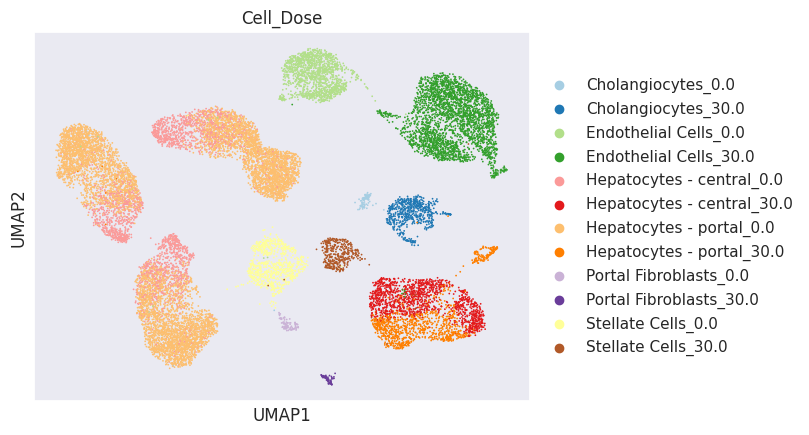

In [74]:
ax = sc.pl.umap(latent_adata, color=['Cell_Dose'], frameon=True,palette = "Paired")

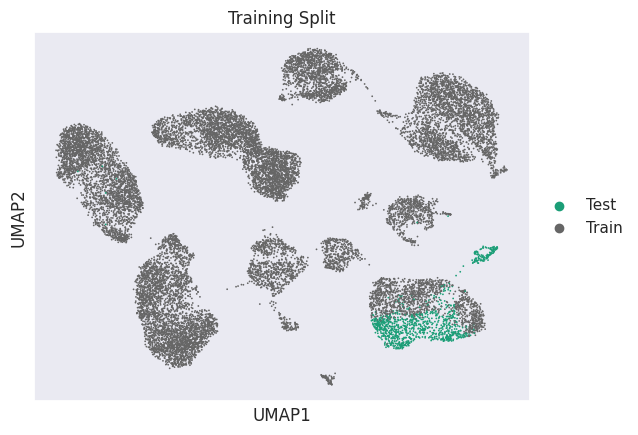

In [75]:
sc.pl.umap(latent_adata, color=['Training Split'], frameon=True,palette ="Dark2")

In [103]:
pred, delta = model.predict(
ctrl_key="0.0",
treat_key="30.0",
cell_type_to_predict=cell,
regression = False)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [104]:
pred

AnnData object with n_obs × n_vars = 2815 × 5000
    obs: 'Dose', 'batch', 'celltype', 'n_counts', 'n_genes', 'condition', 'dose', '_scvi_batch', '_scvi_labels', 'cell_dose'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [80]:
ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs['condition'] == 'control'))]
stim_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs['condition'] == 'stimulated'))]

In [81]:
ctrl_adata

View of AnnData object with n_obs × n_vars = 7492 × 5000
    obs: 'Dose', 'batch', 'celltype', 'n_counts', 'n_genes', 'condition', 'dose', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


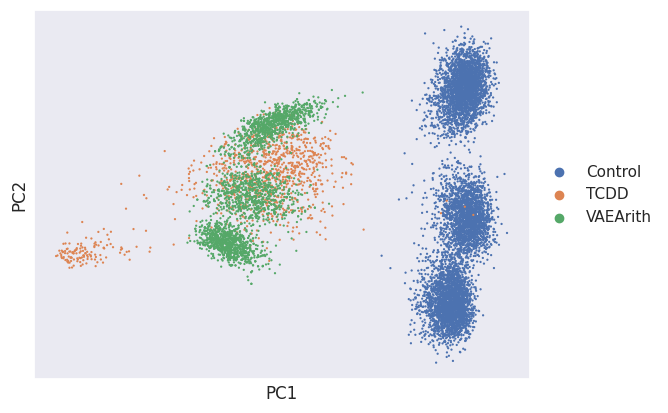

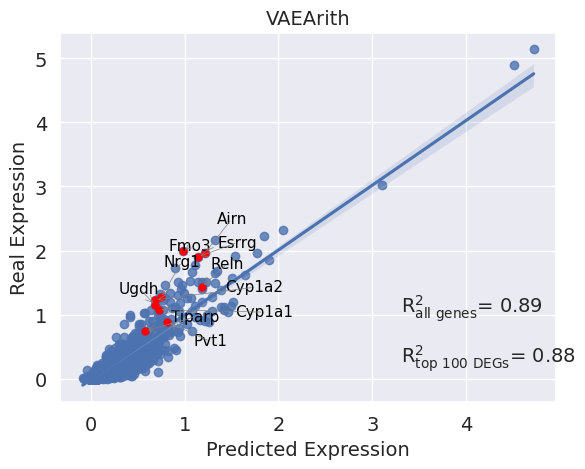

(0.8897596504088929, 0.884371984594991)


In [107]:
pred, delta = model.predict(
ctrl_key="0.0",
treat_key="30.0",
cell_type_to_predict=cell,
regression = False)
pred.obs["dose"] = 'pred'
ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0.0"))]
treat_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30.0"))]
eval_adata1 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata1.obs["dose"]:
    if i == "0.0":
        treatments.append("Control")
    elif i == "30.0":
        treatments.append("TCDD")
    else:
        treatments.append("VAEArith")
eval_adata1.obs["Treatment"] = treatments
sc.tl.pca(eval_adata1)
sc.pl.pca(eval_adata1, color = "Treatment", frameon = True, title = "")
CD4T = adata[adata.obs["celltype"] == cell]
sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30.0"]
r2_value = model.reg_mean_plot(
eval_adata1,
axis_keys={"x": "pred", "y": "30.0"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
save=False,
show=True,
legend=False, title = "VAEArith")
print(r2_value)

saving dotplot to /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/dotplot.pdf
Evaluation figs saved to /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/evaluation.pdf
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/ground_truth
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/predicted
Writing metrics to /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/metrics.csv


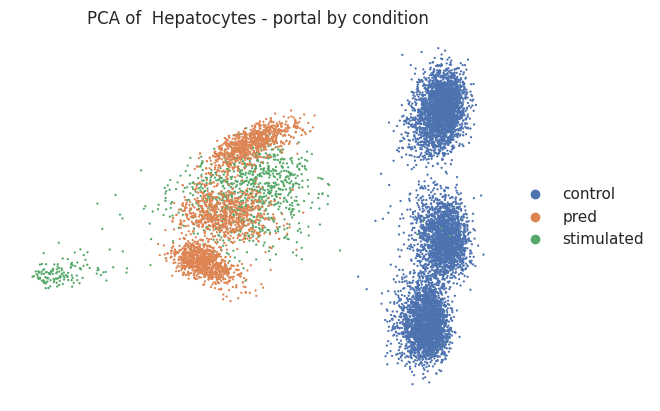

In [105]:
from thesis.utils import FileModelUtils
from thesis.evaluation import evaluation_out_of_sample


model_config = FileModelUtils(
    model_name="VAE_Binary_Prediction_Dioxin_5000g",
    root_path=SAVED_RESULTS_PATH,
    dataset_name="NaultPipeline",
    experiment_name="scvidr",
    perturbation="Dioxin",
    dosage=30)


evaluation_out_of_sample(
    model_config=model_config,
    input=ctrl_adata,
    ground_truth=stim_adata,
    predicted=pred,
    output_path=SAVED_RESULTS_PATH / 'scvidr',
    append_metrics=False,
    save_plots=True,
)

## 2. Multi-Dose